### Importing Necessary Libraries
Few external libraries that we need are as follows:
1. Pandas
2. Numpy
3. Matplotlib
4. NLTK for languange processing
5. Wordcloud for creating wordclouds
6. sci-kit learn, We need CountVectorizer function

In [79]:
import os
import re
import string

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

import nltk
import wordcloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

### Importing Data
Our data were located inside `Data` folder

In [80]:
EXCLUDED_FILES = ["Results.csv"]

def ListFiles(dir: str):
    file_list:list = []
    dir_list:list  = os.listdir(dir)

    for item in dir_list:
        item_dir:str = os.path.join(dir, item)
        if os.path.isdir(item_dir):
            # recusively list directories
            file_list.extend(ListFiles(item_dir))
            print("List dir: {}".format(item_dir))
        else:
            # append file to list
            if item not in EXCLUDED_FILES and item.endswith(".csv"):
                file_list.append(item_dir)

    return file_list
    
file_list = ListFiles("Data")
print ("Found {} files in Data".format(len(file_list)))

List dir: Data/Raw 2022-04-12 15.00
List dir: Data/Raw 2022-04-11 12:30
Found 334 files in Data


In [81]:
def ReadFiles(file_list: list):
    df = None
    for i, file in enumerate(file_list):
        _df = pd.read_csv(file)
        if i == 0:
            df = _df
        else:
            df = pd.concat([df, _df], axis=0, ignore_index=True)

    df = df.drop_duplicates(ignore_index=True, subset="id")
    return df.iloc[:, 1:]

df = ReadFiles(file_list)
df.shape

(532, 38)

In [82]:
USABLE_COLUMNS = ['id', 'date', 'tweet', 'language', 'username', 'user_id', 'retweet', 'nlikes', 'nreplies']
df = df.loc[:, USABLE_COLUMNS]

In [83]:
df.head()

,id,date,tweet,language,username,user_id,retweet,nlikes,nreplies
0,1348907337139036161,2021-01-12 15:19:05,"יום גדול עבור מדינת ישראל כולה, כאשר אנו יכולי...",iw,FleurHassanN,3304041230,False,75,3
1,1326452434181435394,2020-11-11 16:11:19,The historical significance of the peace agree...,en,Bin_Shaiban,453838317,False,116,11
2,1326220222639038466,2020-11-11 00:48:35,Welcome UAE to the F-35 club. Someone in Iran ...,en,AviKaner,18809354,False,65,5
3,1309430143438467072,2020-09-25 16:50:48,שבת שלום לכולם 🇦🇪🇮🇱🇧🇭🇺🇸☮️❤️ #Israel #UAEIsra...,iw,Bin_Shaiban,453838317,False,152,28
4,1309492663620698113,2020-09-25 20:59:14,EXCLUSIVE : The Dubai Airport Free Zone Author...,en,HSajwanization,431777800,False,106,8


we only going to use the english tweets so we will drop every other languages.

In [84]:
print ("Detected languages: \n{}\n".format(df["language"].unique()))

SELECTED_LANGUAGE = 'en'

df = df.loc[df["language"] == SELECTED_LANGUAGE]
print ("Number of Tweet with \'{}\' language: {}\n".format(SELECTED_LANGUAGE, df.shape[0]))

Detected languages: 
['iw' 'en' 'nl' 'pt' 'und' 'es' 'ro' 'in' 'de' 'et' 'fr' 'fa' 'ca' 'it'
 'ar']

Number of Tweet with 'en' language: 490



In [85]:
def CleanText(text: str):
    text = re.sub('@[A-Za-z0–9]+', '', text)    # Remove @mentions
    text = re.sub('#', '', text)                # Remove '#' hash tag
    text = re.sub('RT[\s]+', '', text)          # Remove RT
    text = re.sub('https?:\/\/\S+', '', text)   # Remove hyperlink
    return text

def to_percentage(num:int, whole:int):
    return 100.0 * num / whole


df["tweet"] = df["tweet"].apply(CleanText)
print ("Cleanned sample: \n{}".format(df.tweet.sample(1).iloc[0]))

Cleanned sample: 
Indonesia 🇮🇩 is home to 229,000,000 Muslims - the most in the world. Only 40,000 Indonesians, mostly Christian, visit Israel 🇮🇱 each year. It's time to open the skies and make it much easier for Indonesians and Israelis to visit and get to know each other. AbrahamAccords  


In [86]:
#Assigning Initial Values
positive = 0
negative = 0
neutral = 0

#Creating empty lists
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

#Iterating over the tweets in the dataframe
for i, tweet in enumerate(df['tweet']):
    print ("..processing {}/{}".format(i+1, df.shape[0]), end='\r')
    tweet_list.append(tweet)

    analyzer = SentimentIntensityAnalyzer().polarity_scores(tweet)
    
    neg = analyzer['neg']
    neu = analyzer['neu']
    pos = analyzer['pos']
    comp = analyzer['compound']

    if neg > pos:
        negative_list.append(tweet) #appending the tweet that satisfies this condition
        negative += 1 #increasing the count by 1
    elif pos > neg:
        positive_list.append(tweet) #appending the tweet that satisfies this condition
        positive += 1 #increasing the count by 1
    elif pos == neg:
        neutral_list.append(tweet) #appending the tweet that satisfies this condition
        neutral += 1 #increasing the count by 1 

positive_per = to_percentage(positive, df.shape[0])
negative_per = to_percentage(negative, df.shape[0])
neutral_per  =  to_percentage(neutral,  df.shape[0])

print ("Results:                      ")
print (" {:.2f}\t% positive, \t{} tweets".format(positive_per, positive))
print (" {:.2f}\t% negative, \t{} tweets".format(negative_per, negative))
print (" {:.2f}\t% neutral,  \t{} tweets".format(neutral_per, neutral))
print (" from total of {} tweets".format(df.shape[0]))

Results:                      
 75.10	% positive, 	368 tweets
 7.76	% negative, 	38 tweets
 17.14	% neutral,  	84 tweets
 from total of 490 tweets


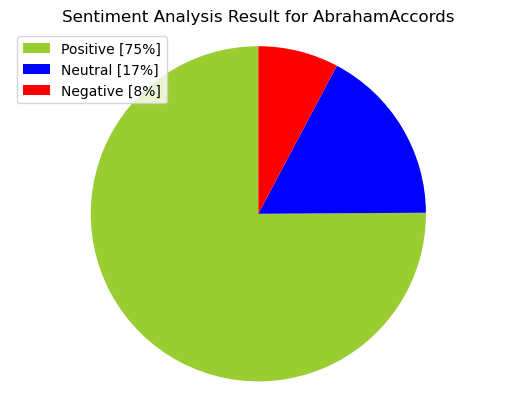

In [87]:
#Creating PieCart

labels = ['Positive ['+str(round(positive_per))+'%]' , 'Neutral ['+str(round(neutral_per))+'%]','Negative ['+str(round(negative_per))+'%]']
sizes = [positive_per, neutral_per, negative_per]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for AbrahamAccords")
plt.axis('equal')
plt.show()

### Cleanning Texts and Doing Word Counting

In [88]:
# Remove RT, Punctuation etc
def clean_text_list(text):
    # Remove RT
    text = re.sub('RT @\w+: ', ' ', text)
    text = re.compile('\#').sub('', re.compile('').sub('', text, count=1).strip())

    # Remove Punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)

    return text.lower()

# Cleaning Text
ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [89]:
_result = map (
            clean_text_list,
            tweet_list
        )
tweet_list = list (_result)

In [90]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tweet_list)
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

490 Number of reviews has 1999 words


,,a,aaaaaaand,abadi,abba,abdulbari,abdulla,abdullah,abdurrahman,abl,...,zay,zayani,zone,zoom,לו,ם,ש,שלום,إبراهيم,سلام
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
peac,219
israel,211
uae,143
,114
amp,84
bahrain,78
sign,67
isra,62
histor,61
uaeisrael,51


### Ngrams

In [92]:
# Function to calculate top ngram
def GetTop_ngrams(corpus, ngram_range, n=None):
    vec = CountVectorizer(
            ngram_range=ngram_range, 
            stop_words='english'
        ).fit(corpus)
        
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

In [93]:
# n2_bigram
n2_bigrams = GetTop_ngrams(tweet_list, (2,2), 20)
n2_bigrams

[('middle east', 46),
 ('abrahamaccords uaeisrael', 23),
 ('uae bahrain', 23),
 ('israel uae', 23),
 ('signing abrahamaccords', 22),
 ('abrahamaccords peace', 21),
 ('peace abrahamaccords', 18),
 ('uae amp', 17),
 ('white house', 17),
 ('peace middle', 16),
 ('uaeisrael abrahamaccords', 15),
 ('israel abrahamaccords', 14),
 ('amp bahrain', 13),
 ('saudi arabia', 13),
 ('peace israel', 13),
 ('historic abrahamaccords', 13),
 ('jared kushner', 11),
 ('peace deal', 10),
 ('israel uaeisrael', 10),
 ('uae abrahamaccords', 10)]

In [94]:
# n3_trigram
n3_trigrams = GetTop_ngrams(tweet_list, (3,3), 20)
n3_trigrams

[('peace middle east', 15),
 ('uae amp bahrain', 12),
 ('united arab emirates', 9),
 ('middle east abrahamaccords', 8),
 ('israel uae bahrain', 7),
 ('abrahamaccords israel uae', 6),
 ('uae bahrain israel', 6),
 ('abrahamaccords uaeisrael israelbahrain', 5),
 ('historic signing abrahamaccords', 5),
 ('israel uae amp', 5),
 ('dubai media office', 4),
 ('uaeisrael israelbahrain peace', 4),
 ('israelbahrain peace israeluae', 4),
 ('middle east peace', 4),
 ('israel uaeisrael abrahamaccords', 4),
 ('nobel peace prize', 4),
 ('abrahamaccords peace israel', 4),
 ('arab countries israel', 3),
 ('new era peace', 3),
 ('new middle east', 3)]

### Creating Word Cloud

In [95]:
# Wordcloud Creation
def create_wordcloud(text, mask: str = "M2jeo.jpg"):
    mask = np.array(Image.open(os.path.join("Mask", mask)))
    stopwords = set(wordcloud.STOPWORDS)

    wc = WordCloud(
                    background_color="white",
                    mask=mask,
                    max_words=3000,
                    stopwords=stopwords,
                    repeat=True
                )

    wc.generate(str(text))
    wc.to_file("wc.png")

In [96]:
create_wordcloud(tweet_list, "twitter_mask.png")

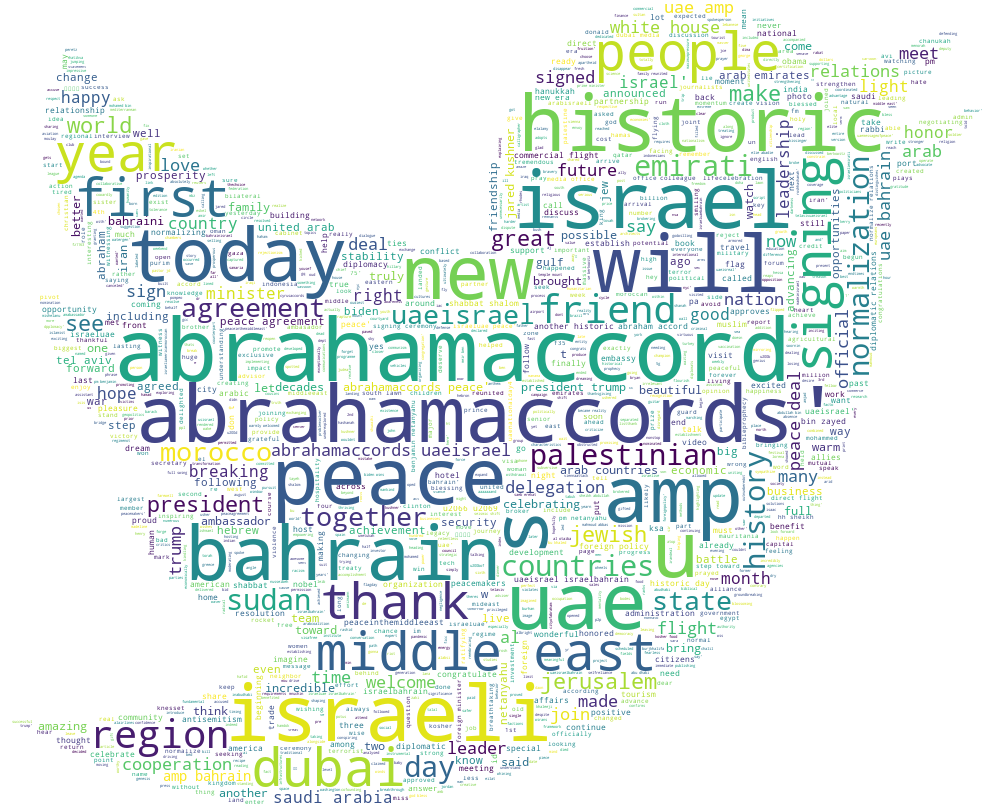

In [97]:
display(Image.open('wc.png'))